In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=cd0e2a2a948b0c41527b9a1cb7aa579c125d90e898cf9b008fd9da3f26ddb58e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


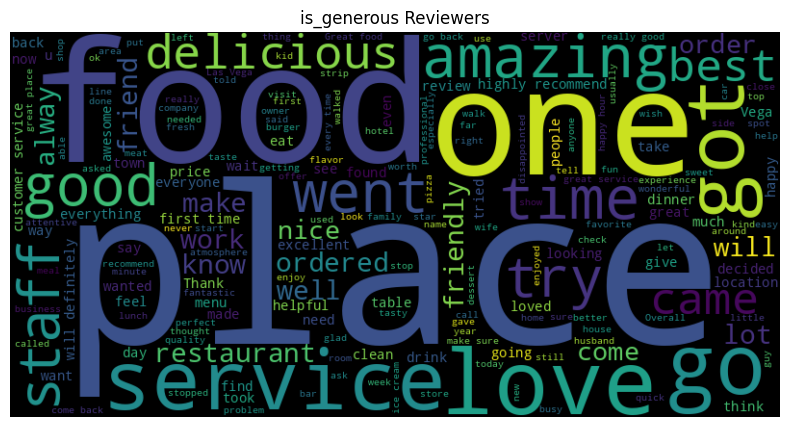

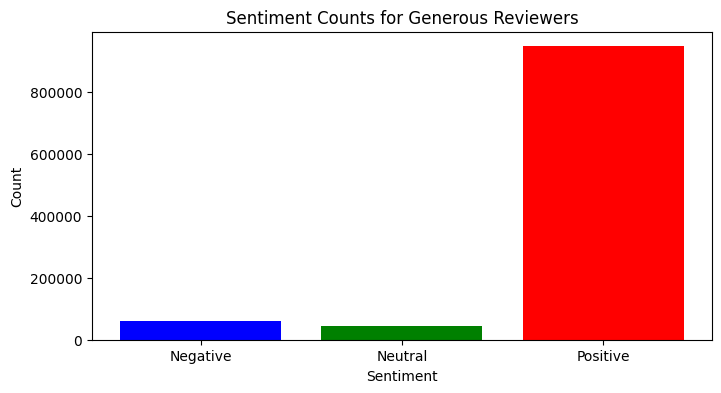

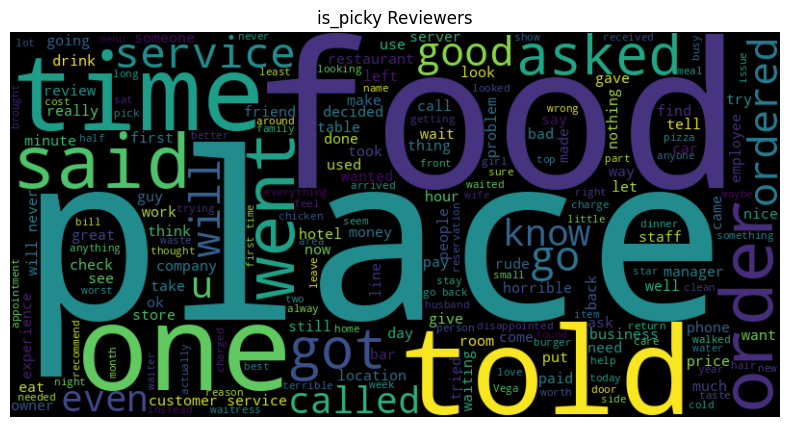

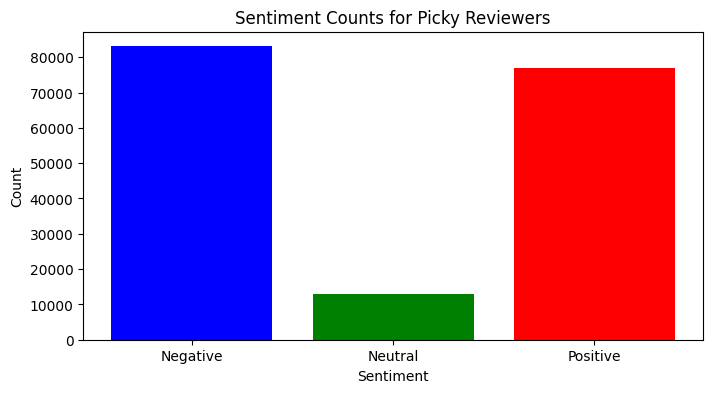

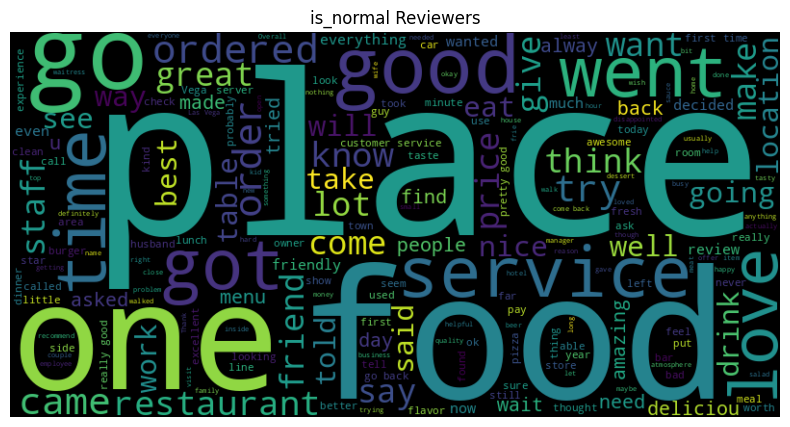

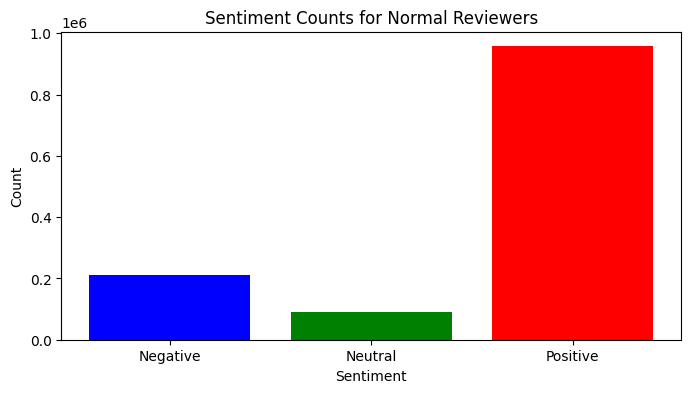

In [2]:
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, avg, broadcast
from pyspark.sql.types import FloatType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from textblob import TextBlob

# Initialize Spark Session
spark = SparkSession.builder.master("local[*]").appName("SentimentAnalysis").getOrCreate()

# Load the dataset
data = spark.read.csv('/content/drive/MyDrive/part-00000-088a67a0-1eba-42ac-af32-e6ff21d882e4-c000.csv', inferSchema=True, header=True)
data = data.dropna(subset=["user_id", "text", "stars"]).drop('date', 'useful', 'funny', 'cool')
data = data.withColumn("stars", col("stars").cast("double"))

# Regex to match user ID pattern
user_id_pattern = r'^[a-zA-Z0-9_-]{22}$'
data = data.filter(col('user_id').rlike(user_id_pattern))

# Calculate average stars and categorize reviewers
user_avg_ratings = data.groupBy("user_id").agg(avg("stars").alias("avg_stars"))
data = data.join(broadcast(user_avg_ratings), "user_id")
data = data.withColumn("is_generous", (col("avg_stars") >= 4).cast("integer")) \
           .withColumn("is_picky", (col("avg_stars") <= 2).cast("integer")) \
           .withColumn("is_normal", ((col("avg_stars") > 2) & (col("avg_stars") < 4)).cast("integer"))

# Define UDFs for sentiment analysis
def get_polarity(text):
    return TextBlob(text).sentiment.polarity if text else 0.0

def classify_sentiment(polarity):
    return 'Positive' if polarity > 0 else 'Negative' if polarity < 0 else 'Neutral'

polarity_udf = udf(get_polarity, FloatType())
classify_sentiment_udf = udf(classify_sentiment, StringType())

# Apply NLP and sentiment analysis pipeline
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])
model = pipeline.fit(data)
df_classified = model.transform(data)
df_classified = df_classified.withColumn("polarity", polarity_udf(col("text")))
df_classified = df_classified.withColumn("sentiment", classify_sentiment_udf(col("polarity")))

# Function to plot sentiment counts
def plot_sentiment_counts(df, category):
    sentiment_counts = df.filter(col(category) == 1).groupBy("sentiment").count().toPandas()
    sentiment_counts.sort_values('sentiment', inplace=True)
    plt.figure(figsize=(8, 4))
    plt.bar(sentiment_counts['sentiment'], sentiment_counts['count'], color=['blue', 'green', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title(f'Sentiment Counts for {category.replace("is_", "").capitalize()} Reviewers')
    plt.show()

# Generate word clouds
def generate_word_clouds(df, category):
    text = " ".join(df.filter(col(category) == 1).select("text").rdd.flatMap(lambda x: x).collect())
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{category} Reviewers")
    plt.show()

# Generate word clouds and plot sentiment counts
generate_word_clouds(df_classified, "is_generous")
plot_sentiment_counts(df_classified, "is_generous")
generate_word_clouds(df_classified, "is_picky")
plot_sentiment_counts(df_classified, "is_picky")
generate_word_clouds(df_classified, "is_normal")
plot_sentiment_counts(df_classified, "is_normal")
